# Configuración e importación de librerias

In [1]:
import datetime
import inspect
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pvlib import solarposition, irradiance, atmosphere, pvsystem
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR

/Users/luisvargas/Desktop/Tesis/pythonPvLib/env/lib/python3.8/site-packages/pvlib/forecast.py:18: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  warnings.warn(


## Cargando los datos de pronostico

In [2]:
#Elegir una lugar usando cordenadas

latitude, longitude, tz = 20.566546, -103.228635, 'America/Mexico_City'

### Se definen algunos parametros fotovoltaicos

In [3]:
surface_tilt = 30
surface_azimuth = 180
albedo = 0.2

In [4]:
start = pd.Timestamp(datetime.date.today(), tz=tz) #El día de hoy
end = start + pd.Timedelta(days=7) #7 dias en adelante

In [5]:
#Definir el modelo de pronostico (forecast model = fm)
fm = GFS()

In [6]:
#Procesar los datos
forecast_data = fm.get_processed_data(latitude, longitude, start, end)

In [7]:
forecast_data.head()

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2020-08-04 06:00:00-05:00,17.149994,1.762259,0.000000,0.000000,0.000000,100.0,13.0,92.0,84.0
2020-08-04 09:00:00-05:00,15.611084,1.846738,109.047104,0.000000,109.047104,88.0,0.0,83.0,64.0
2020-08-04 12:00:00-05:00,14.550018,1.618561,389.908596,34.644064,359.418526,84.0,0.0,69.0,54.0
2020-08-04 15:00:00-05:00,20.888916,1.434458,403.377505,27.495807,376.805475,89.0,0.0,7.0,87.0
2020-08-04 18:00:00-05:00,30.263733,2.077946,275.514416,80.948992,231.282643,66.0,0.0,3.0,65.0


Text(0, 0.5, 'Irradiance ($W/m^2$)')

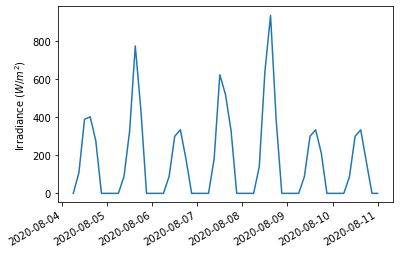

In [8]:
ghi = forecast_data['ghi']
ghi.plot()
plt.ylabel('Irradiance ($W/m^2$)')

Antes de calcular la potencia para todos los tiempos en el pronostico, primero se debe calcular
* solar position
* extra terrestrial radiation
* arimass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures


### Solar position

El algoritmo de posición solar por defecto se basa en Reda y Andreas (2004). La implementación es bastante rapida, se puede hacer aún más rapida si se instala numba y se usa el metodo 'nrel_numba' cuando se llama la función mostrada en la siguiente linea method='nrel_numba'

In [9]:
#Parametros para obtener las posición solar con el metodo .get_solarposition()
time = forecast_data.index
a_point = fm.location

In [10]:
solpos = a_point.get_solarposition(time, method='nrel_numba')

/Users/luisvargas/Desktop/Tesis/pythonPvLib/env/lib/python3.8/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


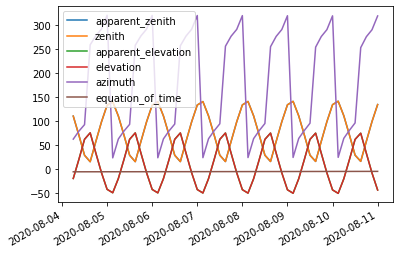

In [11]:
solpos.plot()

### DNI ET (Direct Normal Irradiance Extraterreste)

Calcular la radiación extraterrestre. Esto es necesario para muchos modelos de irradiación difusa en el plano del arreglo

/Users/luisvargas/Desktop/Tesis/pythonPvLib/env/lib/python3.8/site-packages/pvlib/solarposition.py:258: UserWarning: Reloading spa to use numpy
  warnings.warn('Reloading spa to use numpy')


Text(0, 0.5, 'Extra Terrestrial radiation ($W/m^2$)')

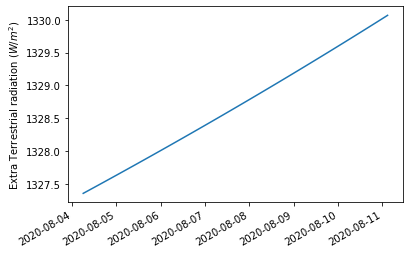

In [12]:
dni_extra = irradiance.get_extra_radiation(fm.time, method='nrel', epoch_year=2020)

dni_extra.plot()
plt.ylabel('Extra Terrestrial radiation ($W/m^2$)')

In [13]:
dni_extra.describe()

count      56.000000
mean     1328.679405
std         0.803148
min      1327.358162
25%      1327.998005
50%      1328.661696
75%      1329.350992
max      1330.068001
dtype: float64

### Airmass

Calcular la masa de aire. Hay muchas opciones de modelos (inchein es mi favorito por su versatilidad)

Text(0, 0.5, 'Airmass')

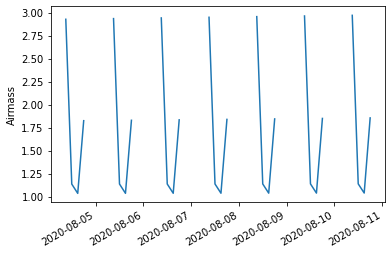

In [14]:
airmass = atmosphere.get_relative_airmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

La appearance is debido a que se solapa por numero invalidos igual a NaN, los desarrolladores sugieren volver a graficat con un o dos dias menos y se verán los numeros correctamente.

In [15]:
airmass.describe()

count    28.000000
mean      1.740274
std       0.777558
min       1.034337
25%       1.111115
50%       1.481235
75%       2.123106
max       2.970609
dtype: float64

In [16]:
airmass

2020-08-04 06:00:00-05:00         NaN
2020-08-04 09:00:00-05:00    2.927635
2020-08-04 12:00:00-05:00    1.135485
2020-08-04 15:00:00-05:00    1.034337
2020-08-04 18:00:00-05:00    1.824689
2020-08-04 21:00:00-05:00         NaN
2020-08-05 00:00:00-05:00         NaN
2020-08-05 03:00:00-05:00         NaN
2020-08-05 06:00:00-05:00         NaN
2020-08-05 09:00:00-05:00    2.934908
2020-08-05 12:00:00-05:00    1.135834
2020-08-05 15:00:00-05:00    1.034839
2020-08-05 18:00:00-05:00    1.829136
2020-08-05 21:00:00-05:00         NaN
2020-08-06 00:00:00-05:00         NaN
2020-08-06 03:00:00-05:00         NaN
2020-08-06 06:00:00-05:00         NaN
2020-08-06 09:00:00-05:00    2.942134
2020-08-06 12:00:00-05:00    1.136195
2020-08-06 15:00:00-05:00    1.035383
2020-08-06 18:00:00-05:00    1.833815
2020-08-06 21:00:00-05:00         NaN
2020-08-07 00:00:00-05:00         NaN
2020-08-07 03:00:00-05:00         NaN
2020-08-07 06:00:00-05:00         NaN
2020-08-07 09:00:00-05:00    2.949315
2020-08-07 1

In [17]:
#airmass.dropna()

In [18]:
#airmass.plot()
#plt.ylabel('Airmass')

In [19]:
#airmass.describe()

### POA Sky difusse (Plano del arreglo en cielo difuso)

Se usa el modelo de Hay Davies para calcular el plano de la radiacion difusa del cielo. Se pueden usar diferentes modelos. Modelo Hay Davies para POA https://pvpmc.sandia.gov/modeling-steps/1-weather-design-inputs/plane-of-array-poa-irradiance/calculating-poa-irradiance/poa-sky-diffuse/hay-sky-diffuse-model/


Determina la irradiancia difusa del cielo para unsa superficie inclinada usando el modelo de Hay Davies de 1980

$I_{d} = DHI ( A R_b + (1 - A) (\frac{1 + \cos\beta}{2}) )$

Text(0, 0.5, 'Irradiance ($W/m^2$)')

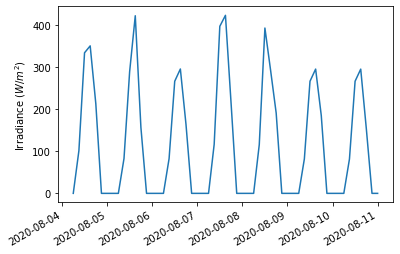

In [20]:
poa_sky_diffuse_haydavies = irradiance.haydavies(surface_tilt, surface_azimuth,
                                                forecast_data['dhi'], forecast_data['dni'], dni_extra,
                                                solpos['apparent_zenith'], solpos['azimuth'])
poa_sky_diffuse_haydavies.plot()
plt.ylabel('Irradiance ($W/m^2$)')

Determina la irradiancia difusa del cielo para unsa superficie inclinada usando el modelo de cielo isotropico

$I_{d} = DHI \frac{1 + \cos\beta}{2}$

Text(0, 0.5, 'Irradiance ($W/m^2$)')

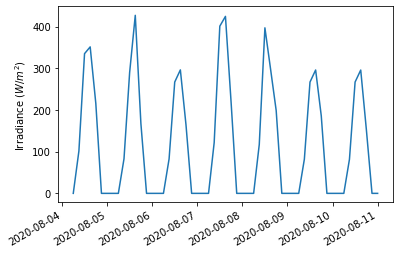

In [21]:
poa_sky_diffuse_isotropic = irradiance.isotropic(surface_tilt, forecast_data['dhi'],)

poa_sky_diffuse_isotropic.plot()
plt.ylabel('Irradiance ($W/m^2$)')

Determina la irradiancia difusa del cielo para una superficie inclinada usando el modelo de Klucher de 1979

$I_{d} = DHI \frac{1 + \cos\beta}{2} (1 + F' \sin^3(\beta/2))
       (1 + F' \cos^2\theta\sin^3\theta_z) $

Text(0, 0.5, 'Irradiance ($W/m^2$)')

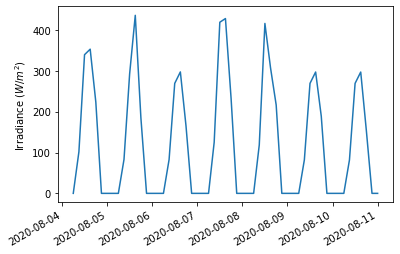

In [22]:
poa_sky_diffuse_klucher = irradiance.klucher(surface_tilt, surface_azimuth,
                                                forecast_data['dhi'], forecast_data['ghi'],
                                                solpos['apparent_zenith'], solpos['azimuth'])

poa_sky_diffuse_klucher.plot()
plt.ylabel('Irradiance ($W/m^2$)')

Determina la irradianza difusa del cielo para una superficie inclinada utilizando el modelo de Reindl de 1990

$ I_{d} = DHI (A R_b + (1 - A) (\frac{1 + \cos\beta}{2})
       (1 + \sqrt{\frac{I_{hb}}{I_h}} \sin^3(\beta/2)) )$

Text(0, 0.5, 'Irradiance ($W/m^2$)')

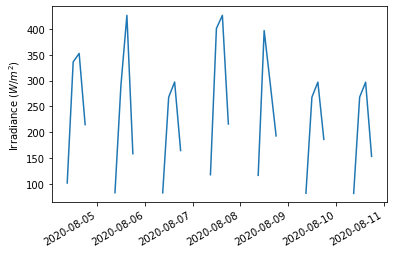

In [23]:
poa_sky_diffuse_reindl = irradiance.reindl(surface_tilt, surface_azimuth,
                                                forecast_data['dhi'], forecast_data['dni'], forecast_data['ghi'],
                                                dni_extra, solpos['apparent_zenith'], solpos['azimuth'])

poa_sky_diffuse_reindl.plot()
plt.ylabel('Irradiance ($W/m^2$)')

Determina la irradianza difusa del cielo para una superficie inclinada utilizando el modelo de King

* King's model determines the diffuse irradiance from the sky (ground
    reflected irradiance is not included in this algorithm) on a tilted
    surface using the surface tilt angle, diffuse horizontal irradiance,
    global horizontal irradiance, and sun zenith angle. Note that this
    model is not well documented and has not been published in any
    fashion (as of January 2012).

Text(0, 0.5, 'Irradiance ($W/m^2$)')

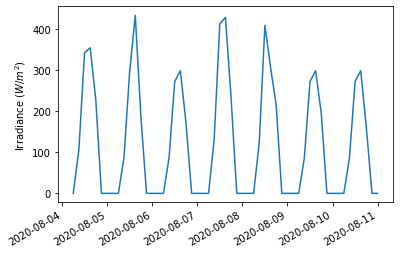

In [24]:
poa_sky_diffuse_king = irradiance.king(surface_tilt, forecast_data['dhi'], forecast_data['ghi'],solpos['apparent_zenith'])

poa_sky_diffuse_king.plot()
plt.ylabel('Irradiance ($W/m^2$)')

### Airmass para el modelo de Perez

In [25]:
#Al parecer hay un problema con los datos de masa de aire para el modelo de perez
# ValueError: operands could not be broadcast together with shapes (55,) (56,)

Determina la irradiancia difusa del cielo para una superficie inclinada usando el modelo de Perez

In [26]:
#poa_sky_diffuse_perez = irradiance.perez(surface_tilt, surface_azimuth, forecast_data['dhi'], forecast_data['dni'], 
#                                         dni_extra, solpos['apparent_zenith'], solpos['azimuth'], airmass)

#poa_sky_diffuse_perez.plot()
#plt.ylabel('Irradiance ($W/m^2$)')

## POA ground diffuse

Calcular la tierra difusa. Este concepto es lo especificado como albedo. Se podría dar como argumento un string para el metodo surface_type

Text(0, 0.5, 'Irradiance ($W/m^2$)')

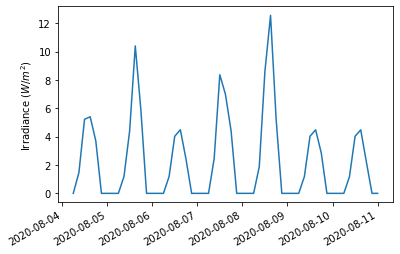

In [27]:
poa_ground_diffuse = irradiance.get_ground_diffuse(surface_tilt, ghi, albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance ($W/m^2$)')

## AOI

Calcular el AOI (angle of incidence) Calcula el ángulo de incidencia del vector solar en una superficie. Este es el ángulo entre el vector solar y la superficie normal. Todos los valores de argumentos deben ser angulos.

Text(0, 0.5, 'Angulo de incidencía (deg)')

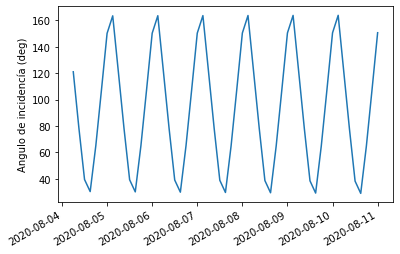

In [28]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angulo de incidencía (deg)')

In [29]:
aoi  #Los valores son raros, yo esperaría a cerca del mediodia el valor fuera 90º, se debe investigar este fenomeno

2020-08-04 06:00:00-05:00    121.064719
2020-08-04 09:00:00-05:00     78.407841
2020-08-04 12:00:00-05:00     39.518871
2020-08-04 15:00:00-05:00     30.390226
2020-08-04 18:00:00-05:00     65.119681
2020-08-04 21:00:00-05:00    107.232549
2020-08-05 00:00:00-05:00    150.160169
2020-08-05 03:00:00-05:00    163.407538
2020-08-05 06:00:00-05:00    121.035105
2020-08-05 09:00:00-05:00     78.318661
2020-08-05 12:00:00-05:00     39.325327
2020-08-05 15:00:00-05:00     30.169599
2020-08-05 18:00:00-05:00     65.054452
2020-08-05 21:00:00-05:00    107.235403
2020-08-06 00:00:00-05:00    150.235905
2020-08-06 03:00:00-05:00    163.494855
2020-08-06 06:00:00-05:00    121.002198
2020-08-06 09:00:00-05:00     78.226307
2020-08-06 12:00:00-05:00     39.127871
2020-08-06 15:00:00-05:00     29.947222
2020-08-06 18:00:00-05:00     64.990632
2020-08-06 21:00:00-05:00    107.239860
2020-08-07 00:00:00-05:00    150.312607
2020-08-07 03:00:00-05:00    163.577577
2020-08-07 06:00:00-05:00    120.965980


## POA Total

Calcular la irradiancia total incidente en el plano del arreglo (plane of array)

Text(0.5, 1.0, 'POA Irradiance')

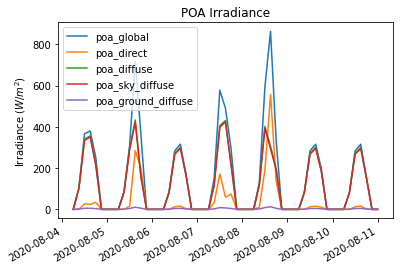

In [30]:
poa_irrad = irradiance.poa_components(aoi, forecast_data['dni'], poa_sky_diffuse_haydavies, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance ($W/m^2$)')
plt.title('POA Irradiance')

## Temperatura del modulo y la celula

<ipython-input-31-cdc159bace7d>:3: pvlibDeprecationWarning: The sapm_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.sapm_cell instead. Note that the arguments and argument order for temperature.sapm_cell are different than for sapm_celltemp
  pvtemps = pvsystem.sapm_celltemp(poa_irrad['poa_global'], wnd_speed, temperature)


Text(0, 0.5, 'Temperatura (ºC)')

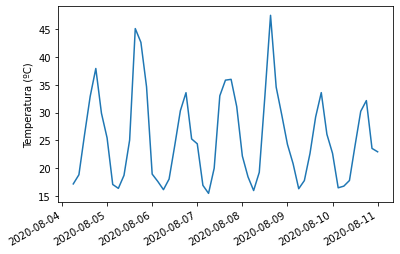

In [31]:
temperature = forecast_data['temp_air']
wnd_speed = forecast_data['wind_speed']
pvtemps = pvsystem.sapm_celltemp(poa_irrad['poa_global'], wnd_speed, temperature)

pvtemps.plot()
plt.ylabel('Temperatura (ºC)')

In [32]:
pvtemps

2020-08-04 06:00:00-05:00    17.149994
2020-08-04 09:00:00-05:00    18.798432
2020-08-04 12:00:00-05:00    26.016653
2020-08-04 15:00:00-05:00    32.899300
2020-08-04 18:00:00-05:00    37.927248
2020-08-04 21:00:00-05:00    29.871490
2020-08-05 00:00:00-05:00    25.430695
2020-08-05 03:00:00-05:00    17.050018
2020-08-05 06:00:00-05:00    16.350006
2020-08-05 09:00:00-05:00    18.691641
2020-08-05 12:00:00-05:00    25.037382
2020-08-05 15:00:00-05:00    45.109639
2020-08-05 18:00:00-05:00    42.626048
2020-08-05 21:00:00-05:00    34.627838
2020-08-06 00:00:00-05:00    18.916473
2020-08-06 03:00:00-05:00    17.592377
2020-08-06 06:00:00-05:00    16.115723
2020-08-06 09:00:00-05:00    18.023797
2020-08-06 12:00:00-05:00    24.038550
2020-08-06 15:00:00-05:00    30.320054
2020-08-06 18:00:00-05:00    33.569387
2020-08-06 21:00:00-05:00    25.245117
2020-08-07 00:00:00-05:00    24.371979
2020-08-07 03:00:00-05:00    16.893860
2020-08-07 06:00:00-05:00    15.450012
2020-08-07 09:00:00-05:00

## Potencia DC usando SAPM

Obtener los datos del modulo

In [33]:
sandia_modules = pvsystem.retrieve_sam('SandiaMod')

Elegír un modulo, pandas.core.frame.DataFrame no muestra todos los modulos hice un for para mostrar todas las columnas que representan el nombre del modulo

In [34]:
for i in sandia_modules.columns:
    print(i)

Advent_Solar_AS160___2006_
Advent_Solar_Ventura_210___2008_
Advent_Solar_Ventura_215___2009_
Aleo_S03_160__2007__E__
Aleo_S03_165__2007__E__
Aleo_S16_165__2007__E__
Aleo_S16_170__2007__E__
Aleo_S16_175__2007__E__
Aleo_S16_180__2007__E__
Aleo_S16_185__2007__E__
AstroPower_AP_100___2001_
AstroPower_AP_100__2000__E__
AstroPower_AP_110___2001_
AstroPower_AP_110__1999__E__
AstroPower_AP_120___2001_
AstroPower_AP_120__1999__E__
AstroPower_AP_1206___1998_
AstroPower_AP_130___2001_
AstroPower_AP_130__2002__E__
AstroPower_AP_50___2001_
AstroPower_AP_50__2000__E__
AstroPower_AP_65__1999__E__
AstroPower_AP_75___2001_
AstroPower_AP_75___2003_
AstroPower_AP_75__2003__E__
AstroPower_AP_8225___1997_
AstroPower_APX_110_SL___2002_
AstroPower_APX_110_SL__2002__E__
AstroPower_APX_120___2001_
AstroPower_APX_120__2002__E__
AstroPower_APX_130___2001_
AstroPower_APX_130__2002__E__
AstroPower_APX_140__2002__E__
AstroPower_APX_40__2002__E__
AstroPower_APX_45___2001_
AstroPower_APX_45__1999__E__
AstroPower_APX_

In [35]:
sandia_module = sandia_modules.Canadian_Solar_CS6X_300M__2013_
sandia_module

Vintage                                                          2013
Area                                                             1.91
Material                                                         c-Si
Cells_in_Series                                                    72
Parallel_Strings                                                    1
Isco                                                           8.6388
Voco                                                          43.5918
Impo                                                           8.1359
Vmpo                                                          34.9531
Aisc                                                           0.0005
Aimp                                                          -0.0001
C0                                                             1.0121
C1                                                            -0.0121
Bvoco                                                         -0.1532
Mbvoc               

   -----
    The SAPM parameters which are required in ``module`` are
    listed in the following table.

    The Sandia module database contains parameter values for a limited set
    of modules. The CEC module database does not contain these parameters.
    Both databases can be accessed using :py:func:`retrieve_sam`.

    ================   ========================================================
    Key                Description
    ================   ========================================================
    A0-A4              The airmass coefficients used in calculating
                       effective irradiance
    B0-B5              The angle of incidence coefficients used in calculating
                       effective irradiance
    C0-C7              The empirically determined coefficients relating
                       Imp, Vmp, Ix, and Ixx to effective irradiance
    Isco               Short circuit current at reference condition (amps)
    Impo               Maximum power current at reference condition (amps)
    Voco               Open circuit voltage at reference condition (amps)
    Vmpo               Maximum power voltage at reference condition (amps)
    Aisc               Short circuit current temperature coefficient at
                       reference condition (1/C)
    Aimp               Maximum power current temperature coefficient at
                       reference condition (1/C)
    Bvoco              Open circuit voltage temperature coefficient at
                       reference condition (V/C)
    Mbvoc              Coefficient providing the irradiance dependence for the
                       BetaVoc temperature coefficient at reference irradiance
                       (V/C)
    Bvmpo              Maximum power voltage temperature coefficient at
                       reference condition
    Mbvmp              Coefficient providing the irradiance dependence for the
                       BetaVmp temperature coefficient at reference irradiance
                       (V/C)
    N                  Empirically determined "diode factor" (dimensionless)
    Cells_in_Series    Number of cells in series in a module's cell string(s)
    IXO                Ix at reference conditions
    IXXO               Ixx at reference conditions
    FD                 Fraction of diffuse irradiance used by module

In [36]:
effective_irradiance = pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, 
                                                          airmass, aoi, sandia_module)

sapm_out = pvsystem.sapm(effective_irradiance, pvtemps, sandia_module)
sapm_out.head()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-08-04 06:00:00-05:00,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2020-08-04 09:00:00-05:00,0.910088,0.869617,40.460816,34.490474,29.993497,NaN,NaN
2020-08-04 12:00:00-05:00,3.134196,2.972693,41.548429,34.644705,102.988059,NaN,NaN
2020-08-04 15:00:00-05:00,3.253770,3.072947,40.515320,33.526878,103.026308,NaN,NaN
2020-08-04 18:00:00-05:00,2.184715,2.060174,38.938809,32.365557,66.678695,NaN,NaN


Text(0, 0.5, 'DC power (W)')

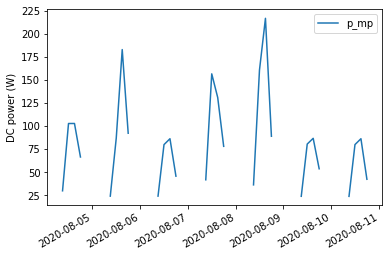

In [37]:
sapm_out[['p_mp']].plot()
plt.ylabel('DC power (W)')

In [38]:
sapm_out['p_mp']

2020-08-04 06:00:00-05:00           NaN
2020-08-04 09:00:00-05:00     29.993497
2020-08-04 12:00:00-05:00    102.988059
2020-08-04 15:00:00-05:00    103.026308
2020-08-04 18:00:00-05:00     66.678695
2020-08-04 21:00:00-05:00           NaN
2020-08-05 00:00:00-05:00           NaN
2020-08-05 03:00:00-05:00           NaN
2020-08-05 06:00:00-05:00           NaN
2020-08-05 09:00:00-05:00     24.224576
2020-08-05 12:00:00-05:00     87.182222
2020-08-05 15:00:00-05:00    183.180848
2020-08-05 18:00:00-05:00     92.448903
2020-08-05 21:00:00-05:00           NaN
2020-08-06 00:00:00-05:00           NaN
2020-08-06 03:00:00-05:00           NaN
2020-08-06 06:00:00-05:00           NaN
2020-08-06 09:00:00-05:00     24.234193
2020-08-06 12:00:00-05:00     80.097384
2020-08-06 15:00:00-05:00     86.481290
2020-08-06 18:00:00-05:00     45.866782
2020-08-06 21:00:00-05:00           NaN
2020-08-07 00:00:00-05:00           NaN
2020-08-07 03:00:00-05:00           NaN
2020-08-07 06:00:00-05:00           NaN


## Potencia alterna (AC Power) usando SAPM

Obtener la base de datos de los inversores

In [39]:
sapm_inverters = pvsystem.retrieve_sam('SandiaInverter')
for i in sapm_inverters.columns:
    print(i)

ABB__MICRO_0_25_I_OUTD_US_208__208V_
ABB__MICRO_0_25_I_OUTD_US_240__240V_
ABB__MICRO_0_3_I_OUTD_US_208__208V_
ABB__MICRO_0_3_I_OUTD_US_240__240V_
ABB__MICRO_0_3HV_I_OUTD_US_208__208V_
ABB__MICRO_0_3HV_I_OUTD_US_240__240V_
ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_
ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_
ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_
ABB__PVI_3_0_OUTD_S_US__208V_
ABB__PVI_3_0_OUTD_S_US__240V_
ABB__PVI_3_0_OUTD_S_US__277V_
ABB__PVI_3_0_OUTD_S_US_A__208V_
ABB__PVI_3_0_OUTD_S_US_A__240V_
ABB__PVI_3_0_OUTD_S_US_A__277V_
ABB__PVI_3_0_OUTD_S_US_Z__208V_
ABB__PVI_3_0_OUTD_S_US_Z__240V_
ABB__PVI_3_0_OUTD_S_US_Z__277V_
ABB__PVI_3_0_OUTD_S_US_Z_A__208V_
ABB__PVI_3_0_OUTD_S_US_Z_A__240V_
ABB__PVI_3_0_OUTD_S_US_Z_A__277V_
ABB__PVI_3_0_OUTD_S_US_Z_M_A__208V_
ABB__PVI_3_0_OUTD_S_US_Z_M_A__240V_
ABB__PVI_3_0_OUTD_S_US_Z_M_A__277V_
ABB__PVI_3_0_OUTD_US__208V_
ABB__PVI_3_0_OUTD_US__240V_
ABB__PVI_3_0_OUTD_US__277V_
ABB__PVI_3_6_OUTD_S_US__208V_
ABB__PVI_3_6_OUTD_S_US__240V_
ABB__PVI_3_6_OUTD_S_US_

GE_Energy__GEPVb_5000_NA_240_01__240V_
GE_Energy__GEPVb_5000_NA_240_208_02__208V_
GE_Energy__GEPVb_5000_NA_240_208_02__240V_
GE_Energy__GEPVe_1100_NA_120__120V_
GE_Energy__GEPVe_2000_NA_240__240V_
GE_Energy__GEPVe_2500_NA_240__240V_
GE_Energy__GEPVe_2800_NA_208__208V_
GE_Energy__GEPVe_3000_NA_240__240V_
GE_Energy__GEPVe_3500_NA_240__240V_
GE_Energy__GEPVe_4600_NA_208__208V_
GE_Energy__GEPVe_4800_NA_240__240V_
GE_Energy__GEPVe_5200_NA_240__240V_
Gefran__APV_1700_2M_TL_US__208V_
Gefran__APV_1700_2M_TL_US__240V_
Gefran__APV_1700_2M_TL_US__277V_
Gefran__APV_2300_2M_TL_US__208V_
Gefran__APV_2300_2M_TL_US__240V_
Gefran__APV_2300_2M_TL_US__277V_
Gefran__APV_3100_2M_TL_US__208V_
Gefran__APV_3100_2M_TL_US__240V_
Gefran__APV_3100_2M_TL_US__277V_
Gefran__APV_3800_2M_TL_US__208V_
Gefran__APV_3800_2M_TL_US__240V_
Gefran__APV_3800_2M_TL_US__277V_
Gefran__APV_4400_2M_TL_US__208V_
Gefran__APV_4400_2M_TL_US__240V_
Gefran__APV_4400_2M_TL_US__277V_
Gefran__APV_5200_2M_TL_US__208V_
Gefran__APV_5200_2M_TL_

SMA_America__STP_62_US_41__480V_
SMA_America__STP12000TL_US_10__480V_
SMA_America__STP15000TL_US_10__480V_
SMA_America__STP20000TL_US_10__480V_
SMA_America__STP24000TL_US_10__480V_
SMA_America__STP30000TL_US_10__480V_
SMA_America__STP50_US_40__480V_
SMA_America__SWR1800U__120V_
SMA_America__SWR1800U_SBD__120V_
SMA_America__SWR2100U__240V_
SMA_America__SWR2100U_SBD__240V_
SMA_America__SWR2500U__208V_
SMA_America__SWR2500U__240V_
SMA_America__SWR2500U_SBD__208V_
SMA_America__SWR2500U_SBD__240V_
SMA_America__Sunny_Island_SI6048
Sainty_Solar__SSI_2K2U__240V_
Sainty_Solar__SSI_3K3U__240V_
Sainty_Solar__SSI_4K4U__240V_
Sainty_Solar__SSI_5K5U__240V_
Samil_Power__SolarPond_240HF_US__208V_
Samil_Power__SolarPond_240HF_US__240V_
Samil_Power__SolarRiver10000TL_US__208V_
Samil_Power__SolarRiver10000TL_US__240V_
Samil_Power__SolarRiver10000TL_US__277V_
Samil_Power__SolarRiver3000TL_US__208V_
Samil_Power__SolarRiver3000TL_US__240V_
Samil_Power__SolarRiver4000TL_US__208V_
Samil_Power__SolarRiver4000T

Yaskawa_Solectria_Solar__PVI_5000S_P__208V_
Yaskawa_Solectria_Solar__PVI_5000S_P__240V_
Yaskawa_Solectria_Solar__PVI_50TL_480__480V_
Yaskawa_Solectria_Solar__PVI_5200TL__208V_
Yaskawa_Solectria_Solar__PVI_5200TL__240V_
Yaskawa_Solectria_Solar__PVI_5300_208__208V_
Yaskawa_Solectria_Solar__PVI_5300_240__240V_
Yaskawa_Solectria_Solar__PVI_5300_POS_208__208V_
Yaskawa_Solectria_Solar__PVI_5300_POS_240__240V_
Yaskawa_Solectria_Solar__PVI_60TL_480__480V_
Yaskawa_Solectria_Solar__PVI_60kW_208__208V_
Yaskawa_Solectria_Solar__PVI_60kW_240
Yaskawa_Solectria_Solar__PVI_60kW_480__180V_
Yaskawa_Solectria_Solar__PVI_6500_208__208V_
Yaskawa_Solectria_Solar__PVI_6500_240__240V_
Yaskawa_Solectria_Solar__PVI_6500_277__277V_
Yaskawa_Solectria_Solar__PVI_6600TL__208V_
Yaskawa_Solectria_Solar__PVI_6600TL__240V_
Yaskawa_Solectria_Solar__PVI_75_kW_208__208V_
Yaskawa_Solectria_Solar__PVI_75_kW_240__240V_
Yaskawa_Solectria_Solar__PVI_75_kW_480__480V_
Yaskawa_Solectria_Solar__PVI_75_kW_480PE
Yaskawa_Solectria_So

In [40]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
sapm_inverter

Vac                          208
Pso                      2.08961
Paco                         250
Pdco                     259.589
Vdco                          40
C0                      -4.1e-05
C1                      -9.1e-05
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                        50
Idcmax                   6.48972
Mppt_low                      30
Mppt_high                     50
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

(0.0, 218.36830994273882)

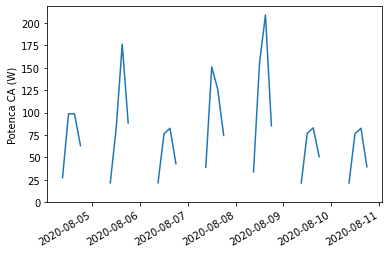

In [41]:
p_ac = pvsystem.snlinverter(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)

p_ac.plot()
plt.ylabel('Potenca CA (W)')
plt.ylim(0, None)

In [42]:
p_ac

2020-08-04 06:00:00-05:00           NaN
2020-08-04 09:00:00-05:00     27.364446
2020-08-04 12:00:00-05:00     98.609332
2020-08-04 15:00:00-05:00     98.646859
2020-08-04 18:00:00-05:00     63.232757
2020-08-04 21:00:00-05:00           NaN
2020-08-05 00:00:00-05:00           NaN
2020-08-05 03:00:00-05:00           NaN
2020-08-05 06:00:00-05:00           NaN
2020-08-05 09:00:00-05:00     21.714414
2020-08-05 12:00:00-05:00     83.221916
2020-08-05 15:00:00-05:00    176.317289
2020-08-05 18:00:00-05:00     88.354078
2020-08-05 21:00:00-05:00           NaN
2020-08-06 00:00:00-05:00           NaN
2020-08-06 03:00:00-05:00           NaN
2020-08-06 06:00:00-05:00           NaN
2020-08-06 09:00:00-05:00     21.723632
2020-08-06 12:00:00-05:00     76.317386
2020-08-06 15:00:00-05:00     82.540033
2020-08-06 18:00:00-05:00     42.900906
2020-08-06 21:00:00-05:00           NaN
2020-08-07 00:00:00-05:00           NaN
2020-08-07 03:00:00-05:00           NaN
2020-08-07 06:00:00-05:00           NaN
